In [15]:
import numpy as np
import imutils
import cv2
from findhomography import *
import matplotlib.pyplot as plt

In [16]:
class Stitcher:
    def __init__(self):
        pass

    def stitch(self, images, ratio=0.85, reprojThresh=4.0,
        showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images

        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB,
            featuresA, featuresB, ratio, reprojThresh)
        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None 
            
        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H,
            (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
                status)
            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)
        # return the stitched image
        return result 

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect and extract features from the image
        descriptor = cv2.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])
        # return a tuple of keypoints and features
        return (kps, features)      


    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx)) 

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

#--------------------------my implement part---------------------------------------#
            # if we don't use ransac, the result is very bad

            # (H1, status) = cv2.findHomography(ptsA, ptsB) 
            (H1, status1) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh) 
  
            # (H2, status2) = findHomography(ptsB, ptsA, 1, 1)
            # (H2, status) = findHomography(ptsB, ptsA)
            #H2=np.linalg.inv(H2)
#-----------------------------------------------------------------------------------#

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H1, status1)

        # otherwise, no homograpy could be computed
        return None                   


    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB
        
        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
        # return the visualization
        return vis

In [49]:
imgA = cv2.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_FRONT_RIGHT__1514864966493989.jpg')
imgB = cv2.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864936124954.jpg')
imgC = cv2.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_BACK__1514864956159109.jpg')
imgD = cv2.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514864956197197.jpg')
imgE = cv2.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_FRONT_LEFT__1514864956138205.jpg')
imgF = cv2.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_FRONT__1514864956220368.jpg')
img1 = cv2.imread('../data/1.jpg')
img2 = cv2.imread('../data/2.jpg')
img3 = cv2.imread('../data/3.jpg')
img4 = cv2.imread('../data/4.jpg')

imgA = cv2.resize(imgA,dsize=(600, 1200))
imgB = cv2.resize(imgB, dsize=(600, 1200))
imgC = imutils.resize(imgC, width=400)
imgD = imutils.resize(imgD, width=400)
imgE = imutils.resize(imgE, width=400)
imgF = imutils.resize(imgF, width=400)

img1 = imutils.resize(img1, width=400)
img2 = imutils.resize(img2, width=400)
img3 = imutils.resize(img3, width=400)
img4 = imutils.resize(img4, width=400)

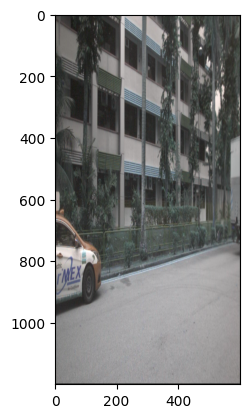

In [60]:
plt.imshow(imgB)

In [32]:
stitcher = Stitcher()

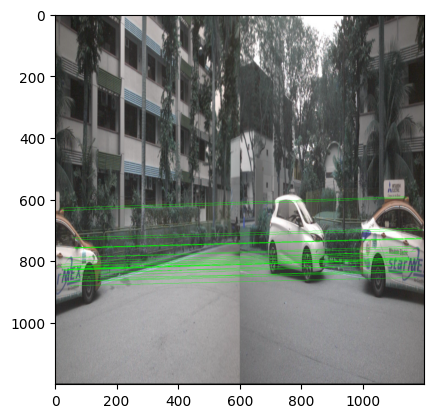

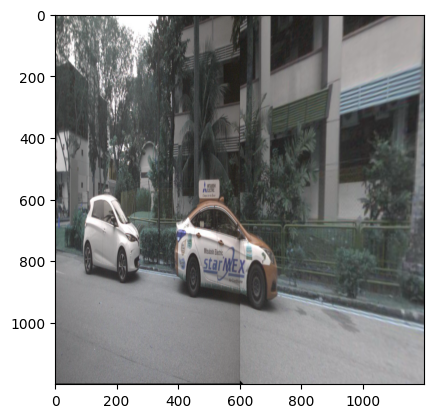

In [64]:
(result1, vis1) = stitcher.stitch([imgA, imgB], ratio=0.8, reprojThresh=4.0, showMatches=True)
plt.imshow(vis1)
plt.show()
plt.imshow(result1)
plt.show()

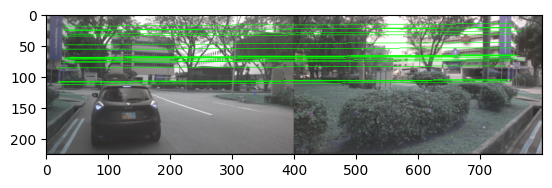

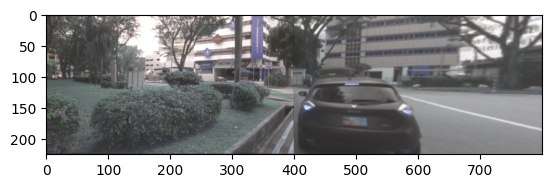

In [20]:
(result2, vis2) = stitcher.stitch([imgE, imgF], ratio=0.75, reprojThresh=2.0,showMatches=True)
cv2.copyMakeBorder(result2, 1000, 1000, 1000, 1000, cv2.BORDER_CONSTANT)
plt.imshow(vis2)
plt.show()
plt.imshow(result2)
plt.show()

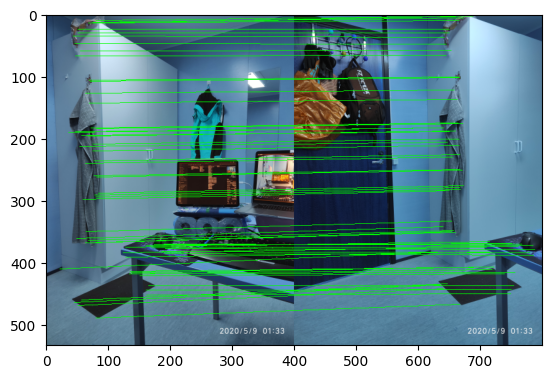

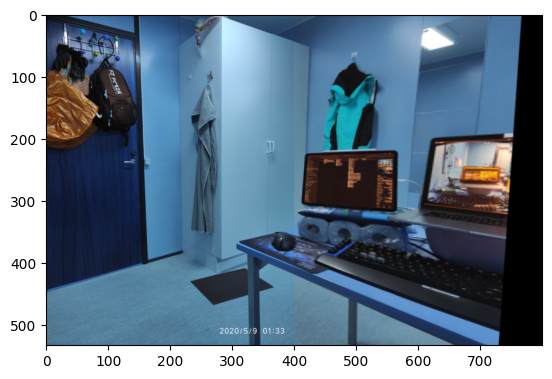

In [33]:
(result3, vis3) = stitcher.stitch([img1, img2], ratio=0.85, reprojThresh=3.0,showMatches=True)
plt.imshow(vis3)
plt.show()
plt.imshow(result3)
plt.show()

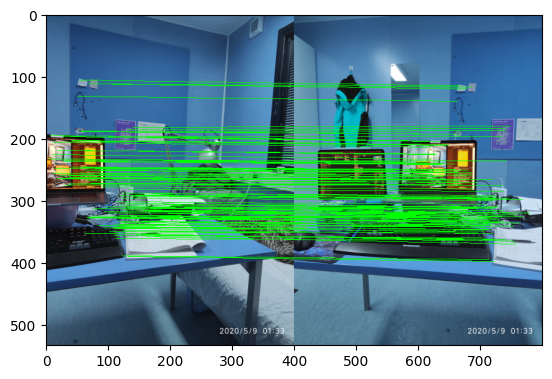

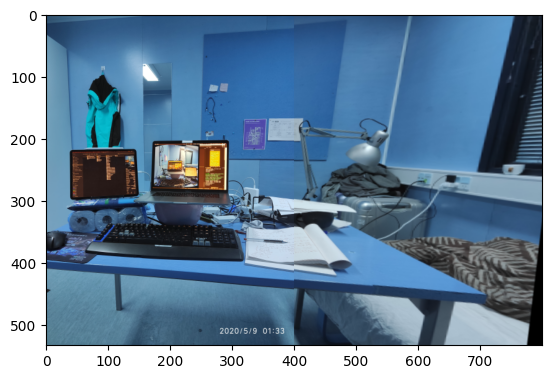

In [34]:
(result4, vis4) = stitcher.stitch([img3, img4], ratio=0.85, reprojThresh=3.0,showMatches=True)
plt.imshow(vis4)
plt.show()
plt.imshow(result4)
plt.show()

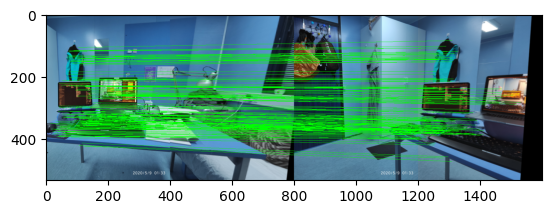

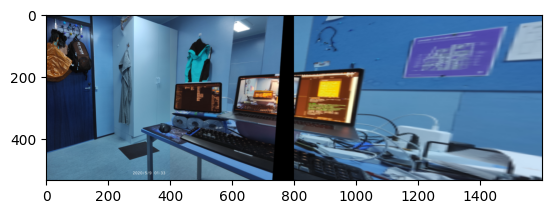

In [36]:
(result5, vis5) = stitcher.stitch([result3, result4], ratio=0.85, reprojThresh=3.0,showMatches=True)
plt.imshow(vis5)
plt.show()
plt.imshow(result5)
plt.show()